In [1]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModel,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
from google.colab import files
trainCSV = files.upload()

df_cnnindonesia = pd.read_csv('cnnindonesia_news_RAW.csv')
df_detikcom = pd.read_csv('detikcom_news_RAW.csv')
df_kompas = pd.read_csv('kompas_news_RAW.csv')
df_turnbackhoax = pd.read_csv('turnbackhoax_2020_2025.csv')

## CLEANING & PREPROCESSING

In [ ]:
# cnn

In [ ]:
df_cnnindonesia.head(2)

,url,judul,tanggal,isi_berita
0,https://www.cnnindonesia.com/nasional/20250420...,Pesan Paskah Uskup Agung Jakarta Kardinal Igna...,"Minggu, 20 Apr 2025 15:07 WIB",Uskup Agung Jakarta Kardinal Mgr. Ignatius Suh...
1,https://www.cnnindonesia.com/olahraga/20250420...,"Mike Tyson: Muhammad Ali Ganas seperti T-Rex, ...","Minggu, 20 Apr 2025 15:01 WIB","Mike Tysonmenyebut legenda tinju dunia,Muhamma..."


In [ ]:
df_cnnindonesia.drop(['url', 'tanggal'], axis=1, inplace = True)

In [ ]:
df_cnnindonesia['media'] = 'cnn'

In [ ]:
df_cnnindonesia.head(2)

,judul,isi_berita,media
0,Pesan Paskah Uskup Agung Jakarta Kardinal Igna...,Uskup Agung Jakarta Kardinal Mgr. Ignatius Suh...,cnn
1,"Mike Tyson: Muhammad Ali Ganas seperti T-Rex, ...","Mike Tysonmenyebut legenda tinju dunia,Muhamma...",cnn


In [ ]:
# detik

In [ ]:
df_detikcom.head(2)

,url,judul,tanggal,isi_berita
0,https://news.detik.com/berita/d-7877560/8-763-...,"8.763 TPS Rampung Gelar PSU di 8 Daerah, KPU P...","Minggu, 20 Apr 2025 20:27 WIB",KetuaKPURI Mochammad Afifuddin mengatakan gela...
1,https://news.detik.com/berita/d-7877557/maruf-...,"Ma'ruf Amin, Dasco hingga Ahmad Dhani Hadiri H...","Minggu, 20 Apr 2025 20:24 WIB",Menteri Koordinator (Menko) Pemberdayaan Masya...


In [ ]:
df_detikcom.drop(['url', 'tanggal'], axis=1, inplace = True)
df_detikcom['media'] = 'detik'
df_detikcom.head(2)

,judul,isi_berita,media
0,"8.763 TPS Rampung Gelar PSU di 8 Daerah, KPU P...",KetuaKPURI Mochammad Afifuddin mengatakan gela...,detik
1,"Ma'ruf Amin, Dasco hingga Ahmad Dhani Hadiri H...",Menteri Koordinator (Menko) Pemberdayaan Masya...,detik


In [ ]:
# kompas

In [ ]:
df_kompas.head(2)

,url,judul,tanggal,isi_berita
0,https://nasional.kompas.com/read/2025/04/20/15...,"Zulhas Persilakan Prabowo Maju Capres 2029, ta...","Kompas.com- 20/04/2025, 15:18 WIB","JAKARTA, KOMPAS.com- Ketua UmumPartai Amanat N..."
1,https://megapolitan.kompas.com/read/2025/04/20...,Bank DKI Pastikan Transaksi Non-Tunai KJP Plus...,"Kompas.com- 20/04/2025, 15:05 WIB","JAKARTA, KOMPAS.com -Bank DKImemastikan layana..."


In [ ]:
df_kompas.drop(['url', 'tanggal'], axis=1, inplace = True)
df_kompas['media'] = 'kompas'
df_kompas.head(2)

,judul,isi_berita,media
0,"Zulhas Persilakan Prabowo Maju Capres 2029, ta...","JAKARTA, KOMPAS.com- Ketua UmumPartai Amanat N...",kompas
1,Bank DKI Pastikan Transaksi Non-Tunai KJP Plus...,"JAKARTA, KOMPAS.com -Bank DKImemastikan layana...",kompas


In [ ]:
# hoaks

In [ ]:
df_turnbackhoax.head(5)

,url,judul,tanggal,isi_berita
0,https://turnbackhoax.id/2025/04/19/penipuan-ta...,[PENIPUAN] Tautan “New Gebyar Program Bank BCA...,"April 19, 2025",Akun Facebook “Gebyar BCA 2025” pada Rabu (26/...
1,https://turnbackhoax.id/2025/04/18/salah-video...,"[SALAH] Video “Ada Bangkai Kereta di Tebing, A...","April 18, 2025",Akun Facebook “Agus Jajang Nurjaman” pada Rabu...
2,https://turnbackhoax.id/2025/04/17/salah-jokow...,"[SALAH] Jokowi Pakai Rp38,5 Triliun Dana Haji ...","April 17, 2025",Pada Sabtu (5/4/2025) beredarunggahandi Facebo...
3,https://turnbackhoax.id/2025/04/17/penipuan-pe...,[PENIPUAN] Pencairan Dana Bansos Kemenkeu,"April 17, 2025",Akun Facebook “bansos bantuan masyarakat” pada...
4,https://turnbackhoax.id/2025/04/17/penipuan-ta...,[PENIPUAN] Tautan “Bantuan Subsidi Upah”,"April 17, 2025",Akun Facebook “Novita Lestariarta” pada Kamis ...


In [ ]:
df_turnbackhoax.drop(['url', 'tanggal'], axis=1, inplace = True)
df_turnbackhoax['media'] = 'hoax'
df_turnbackhoax.head(2)

,judul,isi_berita,media
0,[PENIPUAN] Tautan “New Gebyar Program Bank BCA...,Akun Facebook “Gebyar BCA 2025” pada Rabu (26/...,hoax
1,"[SALAH] Video “Ada Bangkai Kereta di Tebing, A...",Akun Facebook “Agus Jajang Nurjaman” pada Rabu...,hoax


In [ ]:
# PREPROCESS

In [ ]:
# 1. hapus tagline pada judul berita hoaks
def remove_hoax_tags(text):
    if pd.isna(text):
        return ""
    text = re.sub(r'^[\[\(]\s*[^)\]]+\s*[\)\]]', '', text)
    return text

In [ ]:
df_turnbackhoax['judul'] = df_turnbackhoax['judul'].apply(remove_hoax_tags)

In [ ]:
df_turnbackhoax.head()

,judul,isi_berita,media
0,Tautan “New Gebyar Program Bank BCA Tahun 2025”,Akun Facebook “Gebyar BCA 2025” pada Rabu (26/...,hoax
1,"Video “Ada Bangkai Kereta di Tebing, Akibat J...",Akun Facebook “Agus Jajang Nurjaman” pada Rabu...,hoax
2,"Jokowi Pakai Rp38,5 Triliun Dana Haji Rakyat ...",Pada Sabtu (5/4/2025) beredarunggahandi Facebo...,hoax
3,Pencairan Dana Bansos Kemenkeu,Akun Facebook “bansos bantuan masyarakat” pada...,hoax
4,Tautan “Bantuan Subsidi Upah”,Akun Facebook “Novita Lestariarta” pada Kamis ...,hoax


In [ ]:
# 2. labelling

In [ ]:
df_non_hoaks = pd.concat([df_cnnindonesia, df_detikcom, df_kompas], ignore_index=True)
display(df_non_hoaks.head())

,judul,isi_berita,media
0,Pesan Paskah Uskup Agung Jakarta Kardinal Igna...,Uskup Agung Jakarta Kardinal Mgr. Ignatius Suh...,cnn
1,"Mike Tyson: Muhammad Ali Ganas seperti T-Rex, ...","Mike Tysonmenyebut legenda tinju dunia,Muhamma...",cnn
2,Kulkas SBS Banting Harga Gila-gilaan di Transm...,Pesta diskon bertajukTransmart Full Day Saleke...,cnn
3,Hakim Djuyamto Diduga Titip Rp704 Juta ke Satp...,Kejaksaan Agung (Kejagung) menyebut jumlah uan...,cnn
4,Leicester vs Liverpool: Menanti Gol Kaki Kiri ...,Mohamed Salahberpeluang menciptakan rekor unik...,cnn


In [ ]:
df_non_hoaks['hoax'] = 0

In [ ]:
display(df_non_hoaks.head())

,judul,isi_berita,media,hoax
0,Pesan Paskah Uskup Agung Jakarta Kardinal Igna...,Uskup Agung Jakarta Kardinal Mgr. Ignatius Suh...,cnn,0
1,"Mike Tyson: Muhammad Ali Ganas seperti T-Rex, ...","Mike Tysonmenyebut legenda tinju dunia,Muhamma...",cnn,0
2,Kulkas SBS Banting Harga Gila-gilaan di Transm...,Pesta diskon bertajukTransmart Full Day Saleke...,cnn,0
3,Hakim Djuyamto Diduga Titip Rp704 Juta ke Satp...,Kejaksaan Agung (Kejagung) menyebut jumlah uan...,cnn,0
4,Leicester vs Liverpool: Menanti Gol Kaki Kiri ...,Mohamed Salahberpeluang menciptakan rekor unik...,cnn,0


In [ ]:
df_turnbackhoax['hoax'] = 1

In [ ]:
display(df_turnbackhoax.head())

,judul,isi_berita,media,hoax
0,Tautan “New Gebyar Program Bank BCA Tahun 2025”,Akun Facebook “Gebyar BCA 2025” pada Rabu (26/...,hoax,1
1,"Video “Ada Bangkai Kereta di Tebing, Akibat J...",Akun Facebook “Agus Jajang Nurjaman” pada Rabu...,hoax,1
2,"Jokowi Pakai Rp38,5 Triliun Dana Haji Rakyat ...",Pada Sabtu (5/4/2025) beredarunggahandi Facebo...,hoax,1
3,Pencairan Dana Bansos Kemenkeu,Akun Facebook “bansos bantuan masyarakat” pada...,hoax,1
4,Tautan “Bantuan Subsidi Upah”,Akun Facebook “Novita Lestariarta” pada Kamis ...,hoax,1


In [ ]:
df_merged = pd.concat([df_non_hoaks, df_turnbackhoax], ignore_index=True)

In [ ]:
df_merged.head()

,judul,isi_berita,media,hoax
0,Pesan Paskah Uskup Agung Jakarta Kardinal Igna...,Uskup Agung Jakarta Kardinal Mgr. Ignatius Suh...,cnn,0
1,"Mike Tyson: Muhammad Ali Ganas seperti T-Rex, ...","Mike Tysonmenyebut legenda tinju dunia,Muhamma...",cnn,0
2,Kulkas SBS Banting Harga Gila-gilaan di Transm...,Pesta diskon bertajukTransmart Full Day Saleke...,cnn,0
3,Hakim Djuyamto Diduga Titip Rp704 Juta ke Satp...,Kejaksaan Agung (Kejagung) menyebut jumlah uan...,cnn,0
4,Leicester vs Liverpool: Menanti Gol Kaki Kiri ...,Mohamed Salahberpeluang menciptakan rekor unik...,cnn,0


In [ ]:
df_merged['text_clean'] = df_merged['judul'] + ' ' + df_merged['isi_berita']
display(df_merged.head())

,judul,isi_berita,media,hoax,text_clean
0,Pesan Paskah Uskup Agung Jakarta Kardinal Igna...,Uskup Agung Jakarta Kardinal Mgr. Ignatius Suh...,cnn,0,Pesan Paskah Uskup Agung Jakarta Kardinal Igna...
1,"Mike Tyson: Muhammad Ali Ganas seperti T-Rex, ...","Mike Tysonmenyebut legenda tinju dunia,Muhamma...",cnn,0,"Mike Tyson: Muhammad Ali Ganas seperti T-Rex, ..."
2,Kulkas SBS Banting Harga Gila-gilaan di Transm...,Pesta diskon bertajukTransmart Full Day Saleke...,cnn,0,Kulkas SBS Banting Harga Gila-gilaan di Transm...
3,Hakim Djuyamto Diduga Titip Rp704 Juta ke Satp...,Kejaksaan Agung (Kejagung) menyebut jumlah uan...,cnn,0,Hakim Djuyamto Diduga Titip Rp704 Juta ke Satp...
4,Leicester vs Liverpool: Menanti Gol Kaki Kiri ...,Mohamed Salahberpeluang menciptakan rekor unik...,cnn,0,Leicester vs Liverpool: Menanti Gol Kaki Kiri ...


In [ ]:
df_merged.drop(['judul', 'isi_berita'], axis=1, inplace=True)

In [ ]:
df_merged.head()

,media,hoax,text_clean
0,cnn,0,Pesan Paskah Uskup Agung Jakarta Kardinal Igna...
1,cnn,0,"Mike Tyson: Muhammad Ali Ganas seperti T-Rex, ..."
2,cnn,0,Kulkas SBS Banting Harga Gila-gilaan di Transm...
3,cnn,0,Hakim Djuyamto Diduga Titip Rp704 Juta ke Satp...
4,cnn,0,Leicester vs Liverpool: Menanti Gol Kaki Kiri ...


In [ ]:
print(f"Jumlah data di df_merged: {df_merged.shape[0]}")

Jumlah data di df_merged: 25296


In [ ]:
# 3. hapus teks berisi na atau white space

In [ ]:
df_merged.dropna(subset=['text_clean'], inplace=True)
df_merged['text_clean'] = df_merged['text_clean'].str.strip()
df_merged = df_merged[df_merged['text_clean'] != '']

In [ ]:
print(f"Jumlah data di df_merged: {df_merged.shape[0]}")

Jumlah data di df_merged: 25296


In [ ]:
from google.colab import files
trainCSV = files.upload()

df_merged = pd.read_csv('df_merged.csv')

Saving df_merged.csv to df_merged.csv


## EDA

In [ ]:
# EDA
# 1. perbandingan media

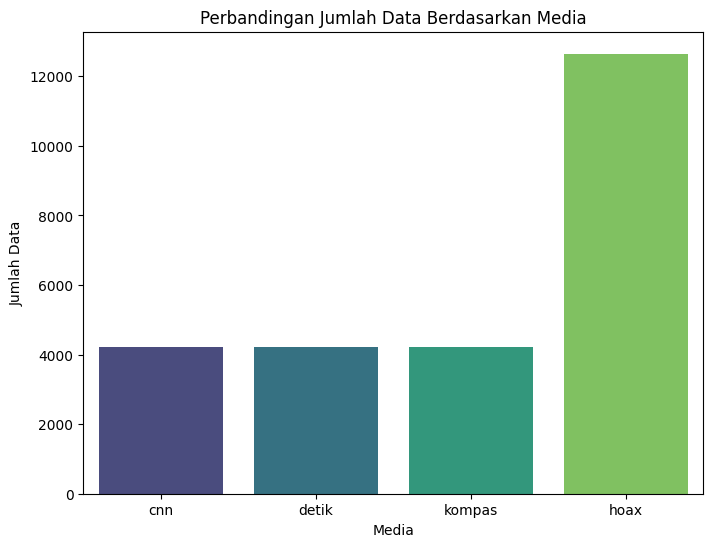

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_merged, x='media', palette='viridis')
plt.title('Perbandingan Jumlah Data Berdasarkan Media')
plt.xlabel('Media')
plt.ylabel('Jumlah Data')
plt.show()

In [ ]:
# 2.perbandingan hoaks non hoaks

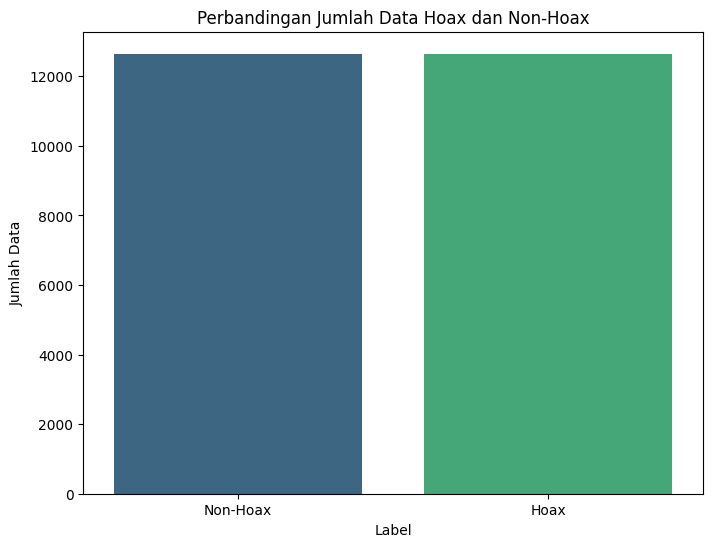

In [ ]:
plt.figure(figsize=(8, 6))
sns.countplot(data=df_merged, x='hoax', palette='viridis')
plt.title('Perbandingan Jumlah Data Hoax dan Non-Hoax')
plt.xlabel('Label')
plt.ylabel('Jumlah Data')
plt.xticks([0, 1], ['Non-Hoax', 'Hoax'])
plt.show()

In [ ]:
# 3. rata-rata panjang teks keseluruhan

In [ ]:
df_merged['text_length'] = df_merged['text_clean'].apply(len)
average_text_length = df_merged['text_length'].mean()
print(f"Rata-rata panjang teks keseluruhan: {average_text_length:.2f}")

Rata-rata panjang teks keseluruhan: 2322.68


In [ ]:
# 4. rata-rata panjang teks tiap media

In [ ]:
average_text_length_by_media = df_merged.groupby('media')['text_length'].mean()
print("Rata-rata panjang teks per media:")
print(average_text_length_by_media)

Rata-rata panjang teks per media:
media
cnn       2238.820209
detik     2419.219639
hoax      2330.049573
kompas    2287.886860
Name: text_length, dtype: float64


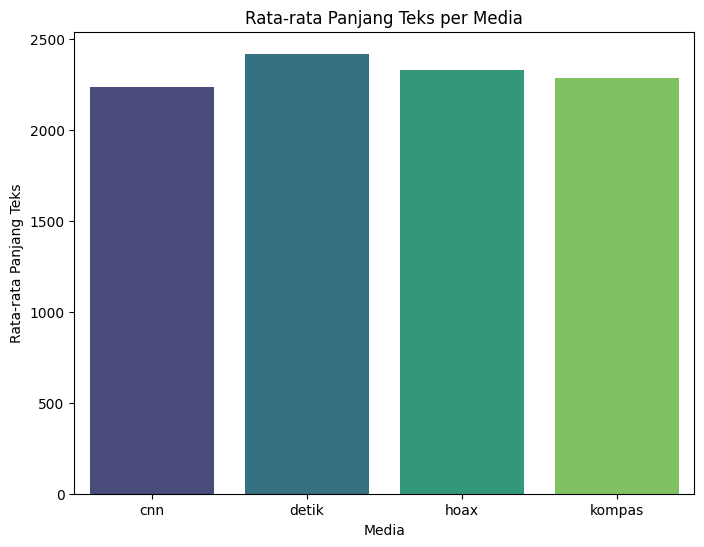

In [ ]:
plt.figure(figsize=(8, 6))
sns.barplot(x=average_text_length_by_media.index, y=average_text_length_by_media.values, palette='viridis')
plt.title('Rata-rata Panjang Teks per Media')
plt.xlabel('Media')
plt.ylabel('Rata-rata Panjang Teks')
plt.show()

In [ ]:
df_merged.head()

,media,hoax,text_clean,text_length
0,cnn,0,Pesan Paskah Uskup Agung Jakarta Kardinal Igna...,3099
1,cnn,0,"Mike Tyson: Muhammad Ali Ganas seperti T-Rex, ...",1670
2,cnn,0,Kulkas SBS Banting Harga Gila-gilaan di Transm...,1529
3,cnn,0,Hakim Djuyamto Diduga Titip Rp704 Juta ke Satp...,1810
4,cnn,0,Leicester vs Liverpool: Menanti Gol Kaki Kiri ...,2084


In [ ]:
df_merged.to_csv('df_merged.csv', index=False)

## MODELLING

# 1. IndoBERT

In [ ]:
# AutoModelForSequenceClassification

In [ ]:
!pip install -q transformers datasets evaluate scikit-learn

from sklearn.model_selection import train_test_split
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModel,
    TrainingArguments,
    Trainer,
)
from datasets import Dataset, DatasetDict
import evaluate

In [ ]:
df = df_merged[['text_clean','hoax']].dropna().rename(columns={'text_clean':'text','hoax':'label'})
df['label'] = df['label'].astype(int)

# Xplit train/valid/test (80/10/10)
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

ds = DatasetDict({
    "train": Dataset.from_pandas(train_df.reset_index(drop=True)),
    "validation": Dataset.from_pandas(valid_df.reset_index(drop=True)),
    "test": Dataset.from_pandas(test_df.reset_index(drop=True)),
})

# Model & tokenizer IndoBERT
MODEL_NAME = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)

max_len = 370
def tokenize_fn(batch):
    return tokenizer(
        batch["text"],
        padding="max_length",
        truncation=True,
        max_length=max_len,
    )

tokenized = ds.map(tokenize_fn, batched=True, remove_columns=['text'])
tokenized = tokenized.rename_column("label", "labels")
tokenized.set_format(type="torch")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/20236 [00:00<?, ? examples/s]

Map:   0%|          | 0/2530 [00:00<?, ? examples/s]

Map:   0%|          | 0/2530 [00:00<?, ? examples/s]

In [ ]:
# Metrics
accuracy = evaluate.load("accuracy")
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        "accuracy": accuracy.compute(predictions=preds, references=labels)["accuracy"],
        "precision": precision.compute(predictions=preds, references=labels, average="binary")["precision"],
        "recall": recall.compute(predictions=preds, references=labels, average="binary")["recall"],
        "f1": f1.compute(predictions=preds, references=labels, average="binary")["f1"],
    }

In [ ]:
# model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

# Training args
args = TrainingArguments(
    output_dir="./indobert-hoax-cls",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    num_train_epochs=2,
    weight_decay=0.01,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    seed=42,
)

# Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Map:   0%|          | 0/20236 [00:00<?, ? examples/s]

Map:   0%|          | 0/2530 [00:00<?, ? examples/s]

Map:   0%|          | 0/2530 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

# Evaluasi valid & test
print("== Valid ==")
print(trainer.evaluate(tokenized["validation"]))

print("== Test ==")
print(trainer.evaluate(tokenized["test"]))

# Inference contoh
samples = [
    "Vaksin COVID-19 mengandung microchip untuk melacak manusia",
    "Pemerintah merilis data inflasi bulan ini melalui BPS",
]
enc = tokenizer(samples, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(trainer.model.device)
with torch.no_grad():
    logits = trainer.model(**enc).logits
preds = logits.argmax(dim=-1).cpu().tolist()
for s, p in zip(samples, preds):
    print(f"[{p}] {s}")

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000000,0.003542,0.998814,0.997634,1.000000,0.998816
2,0.000000,0.009483,0.998814,1.000000,0.997628,0.998813


== Valid ==


{'eval_loss': 0.0035423533990979195, 'eval_accuracy': 0.9988142292490119, 'eval_precision': 0.9976340694006309, 'eval_recall': 1.0, 'eval_f1': 0.9988156336360048, 'eval_runtime': 14.2979, 'eval_samples_per_second': 176.95, 'eval_steps_per_second': 22.171, 'epoch': 2.0}
== Test ==
{'eval_loss': 0.005499518476426601, 'eval_accuracy': 0.9988142292490119, 'eval_precision': 0.9976340694006309, 'eval_recall': 1.0, 'eval_f1': 0.9988156336360048, 'eval_runtime': 14.9074, 'eval_samples_per_second': 169.715, 'eval_steps_per_second': 21.265, 'epoch': 2.0}
[1] Vaksin COVID-19 mengandung microchip untuk melacak manusia
[0] Pemerintah merilis data inflasi bulan ini melalui BPS


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

<Figure size 500x500 with 0 Axes>

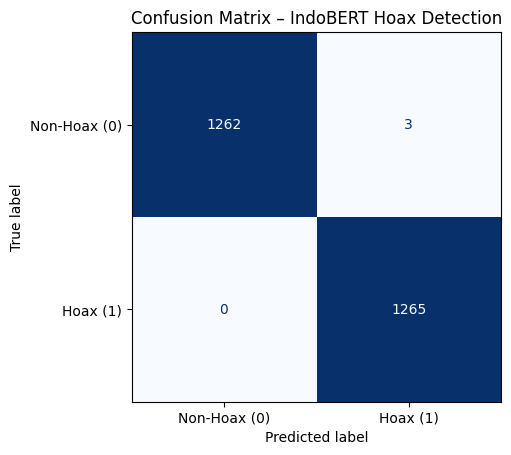

In [ ]:
# --- Confusion Matrix ---
preds_output = trainer.predict(tokenized["test"])
pred_labels = np.argmax(preds_output.predictions, axis=1)
true_labels = preds_output.label_ids

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Hoax (0)", "Hoax (1)"])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d', colorbar=False)
plt.title("Confusion Matrix – IndoBERT Hoax Detection")
plt.show()

In [ ]:
trainer.save_model("./indobert-hoax-nonfreeze")

In [ ]:
# AutoModel -> freeze layer 1 - 7

In [ ]:
!pip install -q transformers datasets scikit-learn evaluate torch

In [ ]:
# freeze layer 1–7
class IndoBERT_HoaxClassifier(nn.Module):
    def __init__(self, model_name, num_labels=2, dropout_p=0.2):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)

        for name, param in self.encoder.named_parameters():
            if any(f"layer.{i}." in name for i in range(0, 7)):
                param.requires_grad = False

        self.dropout = nn.Dropout(dropout_p)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]
        pooled = self.dropout(pooled)
        logits = self.classifier(pooled)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits, labels)
        return {"loss": loss, "logits": logits}

model = IndoBERT_HoaxClassifier(MODEL_NAME)

# Training arguments
args = TrainingArguments(
    output_dir="./indobert-freeze",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

# Evaluasi
print("== Validation ==")
print(trainer.evaluate(tokenized["validation"]))

print("== Test ==")
print(trainer.evaluate(tokenized["test"]))

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.000700,0.000418,0.999605,1.000000,0.999209,0.999605
2,0.000000,0.004182,0.999209,0.999209,0.999209,0.999209


== Validation ==


{'eval_loss': 0.0004182964039500803, 'eval_accuracy': 0.999604743083004, 'eval_precision': 1.0, 'eval_recall': 0.9992094861660079, 'eval_f1': 0.9996045867931989, 'eval_runtime': 14.1391, 'eval_samples_per_second': 178.936, 'eval_steps_per_second': 22.42, 'epoch': 2.0}
== Test ==
{'eval_loss': 5.92602100368822e-06, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 14.6945, 'eval_samples_per_second': 172.173, 'eval_steps_per_second': 21.573, 'epoch': 2.0}


<Figure size 500x500 with 0 Axes>

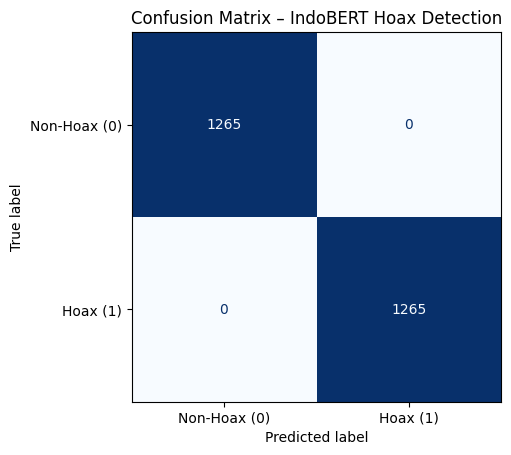

In [ ]:
# --- Confusion Matrix ---
preds_output = trainer.predict(tokenized["test"])
pred_labels = np.argmax(preds_output.predictions, axis=1)
true_labels = preds_output.label_ids

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Hoax (0)", "Hoax (1)"])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d', colorbar=False)
plt.title("Confusion Matrix – IndoBERT Hoax Detection")
plt.show()

In [ ]:
trainer.save_model("./indobert-freeze")

## 2. Indo BERTTweet

In [ ]:
# AutoModelForSequenceClassification

In [ ]:
MODEL_NAME = "indolem/indobertweet-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)

args = TrainingArguments(
    output_dir="./indobertweet-hoax-cls",
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    report_to="none",
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indolem/indobertweet-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
trainer.train()

print("== Validation ==")
print(trainer.evaluate(tokenized["validation"]))

print("== Test ==")
print(trainer.evaluate(tokenized["test"]))

# Inference contoh
samples = [
    "Vaksin COVID-19 mengandung microchip untuk melacak manusia",
    "Pemerintah merilis data inflasi bulan ini melalui BPS",
]
enc = tokenizer(samples, padding=True, truncation=True, max_length=max_len, return_tensors="pt").to(trainer.model.device)
with torch.no_grad():
    logits = trainer.model(**enc).logits
preds = logits.argmax(dim=-1).cpu().tolist()
for s, p in zip(samples, preds):
    print(f"[{p}] {s}")


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.020000,0.019868,0.997628,1.000000,0.995257,0.997623
2,0.000000,0.007323,0.998814,0.999209,0.998419,0.998814


== Validation ==


{'eval_loss': 0.007322946097701788, 'eval_accuracy': 0.9988142292490119, 'eval_precision': 0.9992088607594937, 'eval_recall': 0.9984189723320158, 'eval_f1': 0.9988137603795967, 'eval_runtime': 13.3398, 'eval_samples_per_second': 189.658, 'eval_steps_per_second': 23.764, 'epoch': 2.0}
== Test ==
{'eval_loss': 0.0019490837585180998, 'eval_accuracy': 0.999604743083004, 'eval_precision': 1.0, 'eval_recall': 0.9992094861660079, 'eval_f1': 0.9996045867931989, 'eval_runtime': 13.8612, 'eval_samples_per_second': 182.524, 'eval_steps_per_second': 22.87, 'epoch': 2.0}
[1] Vaksin COVID-19 mengandung microchip untuk melacak manusia
[1] Pemerintah merilis data inflasi bulan ini melalui BPS


In [ ]:
# CARA LOAD MODEL

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("./berttweet-nonfreeze")

args = TrainingArguments(
    output_dir="./indobertweet-hoax-cls",
    per_device_eval_batch_size=8,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<Figure size 500x500 with 0 Axes>

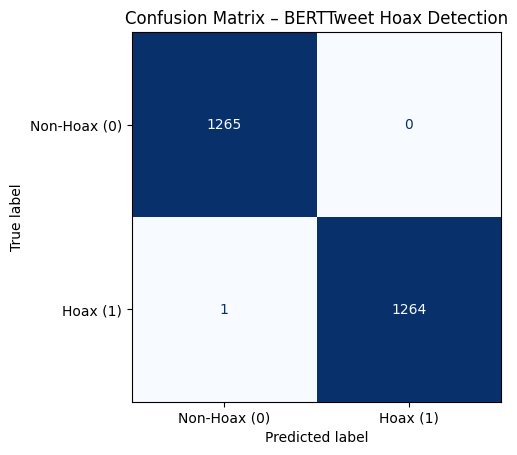

<Figure size 640x480 with 0 Axes>

In [ ]:
preds_output = trainer.predict(tokenized["test"])
pred_labels = np.argmax(preds_output.predictions, axis=1)
true_labels = preds_output.label_ids

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Hoax (0)", "Hoax (1)"])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d', colorbar=False)
plt.title("Confusion Matrix – BERTTweet Hoax Detection")
plt.show()
plt.savefig("confusion_matrix_berttweet_non_freeze.png")

In [ ]:
trainer.save_model("./berttweet-nonfreeze")

In [ ]:
# AutoModel -> freeze 7 layer

In [ ]:
MODEL = "indolem/indobertweet-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL, use_fast=True)

class IndoBERTweetHoaxCls(nn.Module):
    def __init__(self, model_name, num_labels=2, dropout=0.2):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        # freeze 7
        for name, p in self.encoder.named_parameters():
            if any(f"layer.{i}." in name for i in range(0, 7)):
                p.requires_grad = False
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(self.encoder.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask, labels=None):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        cls = out.last_hidden_state[:, 0]
        logits = self.classifier(self.dropout(cls))
        loss = None
        if labels is not None:
            loss = nn.CrossEntropyLoss()(logits, labels)
        return {"loss": loss, "logits": logits}

model = IndoBERTweetHoaxCls(MODEL)

# Metrics
acc = evaluate.load("accuracy")
f1  = evaluate.load("f1")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {"accuracy": acc.compute(predictions=preds, references=labels)["accuracy"],
            "f1": f1.compute(predictions=preds, references=labels, average="binary")["f1"]}

# sederhana
args = TrainingArguments(
    output_dir="./indobertweet-freeze7",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none",
    seed=42,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

print("== Validation ==")
print(trainer.evaluate(tokenized["validation"]))
print("== Test ==")
print(trainer.evaluate(tokenized["test"]))

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.005000,0.012050,0.998814,0.998813


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.005000,0.012050,0.998814,0.998813
2,0.002800,0.009007,0.999209,0.999209


== Validation ==


{'eval_loss': 0.009006751701235771, 'eval_accuracy': 0.9992094861660079, 'eval_f1': 0.9992088607594937, 'eval_runtime': 13.0287, 'eval_samples_per_second': 194.187, 'eval_steps_per_second': 24.331, 'epoch': 2.0}
== Test ==
{'eval_loss': 4.534193749350379e-07, 'eval_accuracy': 1.0, 'eval_f1': 1.0, 'eval_runtime': 13.4741, 'eval_samples_per_second': 187.768, 'eval_steps_per_second': 23.527, 'epoch': 2.0}


<Figure size 500x500 with 0 Axes>

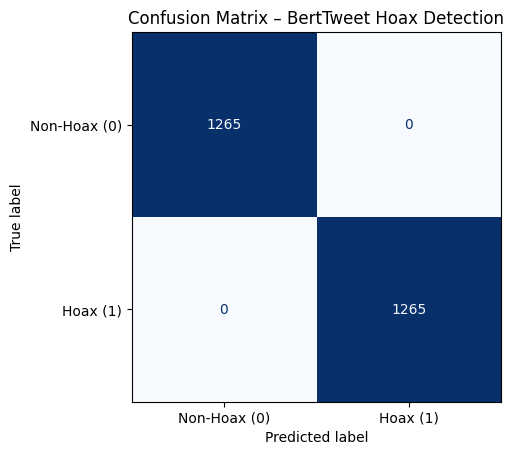

<Figure size 640x480 with 0 Axes>

In [ ]:
# --- Confusion Matrix ---
preds_output = trainer.predict(tokenized["test"])
pred_labels = np.argmax(preds_output.predictions, axis=1)
true_labels = preds_output.label_ids

cm = confusion_matrix(true_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-Hoax (0)", "Hoax (1)"])

plt.figure(figsize=(5, 5))
disp.plot(cmap='Blues', values_format='d', colorbar=False)
plt.title("Confusion Matrix – BertTweet Hoax Detection")
plt.show()
plt.savefig("confusion_matrix_berttweet_freeze.png")

In [ ]:
import os, glob
print("CWD:", os.getcwd())  # lokasi folder kerja saat ini
print([p for p in glob.glob("confusion_matrix_berttweet_freeze.png")])


CWD: /content
['confusion_matrix_berttweet_freeze.png']


In [ ]:
trainer.save_model("./berttweet-freeze")